## Pipeline Building for Regularised LR and XGBoost algorithms

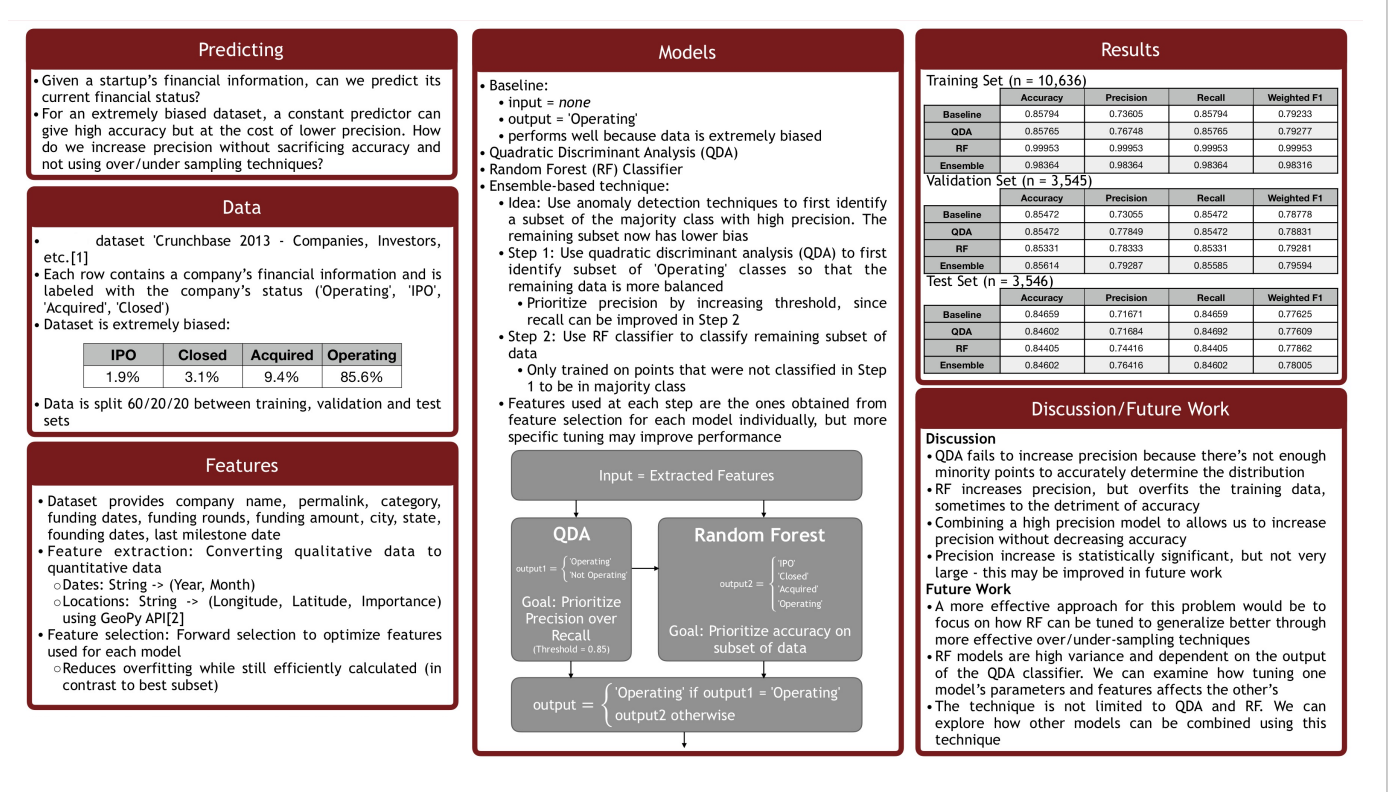

### Approach:<br>
Selecting bivariate model based on higher precision of Operating class<br>

Building multivariate model based on the records that bivariate model was not able to predict as Operating class<br>

Selecting multivariate model based on higher accuracy<br>

Combining the predictions of both models and calculating final accuracy.<br>

In [ ]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in cast")
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.optimize.linesearch")
warnings.filterwarnings('ignore')


In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Import Classification Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error , confusion_matrix , classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split ,GridSearchCV

# Import Feature Engineering Techniques
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest , chi2, mutual_info_regression

# Import Classification Models
from sklearn.linear_model import  Lasso , Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif

# Import the matplotlib and seaborn libraries for plotting
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib notebook
import seaborn as sns
sns.set()
import plotly
import plotly.express as px

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve, train_test_split
from xgboost import XGBClassifier

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn import set_config
import pickle


In [ ]:
target_names = [ 'Closed', 'Operating']
def model_accuracy(actual, predicted):
    confusion_mat = confusion_matrix(actual, predicted)
    class_report = classification_report(actual, predicted,  target_names= target_names )

    print(f"accuracy: {round(accuracy_score(actual, predicted),2)}")
    print(f"precision: {round(precision_score(actual, predicted),2)}")
    print(f"recall/sensitivity: {round(recall_score(actual, predicted),2)}")
    print(class_report)
    print(confusion_mat)
    # Plot Confusion Matrix
    sns.heatmap(confusion_mat,annot=True, fmt='d', annot_kws={'fontsize': 20})
    plt.show()

def multiclass_model_accuracy(part, actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    confusion_mat = confusion_matrix(actual, predicted)
    precision = precision_score(actual, predicted, average="macro")
    recall = recall_score(actual, predicted,average="macro")
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    print(f"{part}_accuracy: {round(accuracy,2)}")
    print(f"{part}_precision: {round(precision,2)}")
    print(f"{part}_recall/sensitivity: {round(recall,2)}")
    print(f"\nMean Absolute Error: {round(mae,2)}")
    print(f"Root Mean Squared Error: {round(rmse,2)}")
    print(f"Confusion Matrix of {part} data")
    print(confusion_mat)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FE_data.csv')
df = dataset.copy()
df.head(5)

,status,founded_at,investment_rounds,funding_rounds,funding_total_usd,milestones,relationships,ROI,active_days,category_code_biotech,category_code_ecommerce,category_code_enterprise,category_code_games_video,category_code_hardware,category_code_health,category_code_mobile,category_code_other,category_code_software,category_code_web,country_code_CAN,country_code_DEU,country_code_ESP,country_code_FRA,country_code_GBR,country_code_IND,country_code_IRL,country_code_ISR,country_code_USA,country_code_other,status_class,funding_usd_for_1_round,milestone_diff,funding_year_diff,Age_group_2500-4000,Age_group_4000-5500,Age_group_5500-7000,Age_group_7000-10000
0,1,2003,1.0,1.0,250000.0,1.0,2.000000,6.500497,6570.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,250000.0,0.0,0.0,0,0,1,0
1,1,2010,1.0,1.0,100000.0,1.0,2.852067,6.500497,4015.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,100000.0,0.0,0.0,0,1,0,0
2,1,2004,1.0,1.0,1500000.0,1.0,8.000000,6.500497,6205.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1500000.0,0.0,0.0,0,0,1,0
3,1,2011,1.0,1.0,40000.0,1.0,5.000000,6.500497,3650.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,40000.0,0.0,0.0,1,0,0,0
4,1,2007,1.0,1.0,350000.0,1.0,2.000000,6.500497,5110.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,350000.0,0.0,0.0,0,1,0,0


In [ ]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [ ]:
inputs = df.drop(['status','status_class'], axis=1)
target = df['status']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, target, stratify = target ,random_state=365)

In [ ]:
train_index = X_train.index
test_index = X_test.index

In [ ]:
X_train_5 = X_train.copy()
X_test_5 = X_test.copy()

In [ ]:
X_train_5.reset_index(drop=True, inplace=True)
X_test_5.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# 1

In [ ]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=5)),
    ('model', LogisticRegression(penalty='l2', C= 10 , max_iter=100, solver= 'newton-cg'))
    ])

In [ ]:
set_config(display="diagram")
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('feature_selector',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_classif at 0x782005d40430>)),
                ('model', LogisticRegression(C=10, solver='newton-cg'))])

In [ ]:
Operating_prob = pipeline.predict_proba(X_train)[:,1]
LR_training_result = pd.DataFrame()
LR_training_result["Operating_prob"] = Operating_prob
LR_training_result['predicted'] = LR_training_result.Operating_prob.map( lambda x: 1 if x > 0.9 else 0)
LR_training_result['actual'] = y_train
LR_training_result.head(5)

,Operating_prob,predicted,actual
0,0.983176,1,1
1,0.826222,0,1
2,0.982471,1,1
3,0.978667,1,1
4,0.985428,1,1


In [ ]:
LR_training_result.isna().sum()

Operating_prob    0
predicted         0
actual            0
dtype: int64

In [ ]:
model_accuracy(LR_training_result['actual'] , LR_training_result['predicted'])

accuracy: 0.86
precision: 0.97
recall/sensitivity: 0.87
              precision    recall  f1-score   support

      Closed       0.48      0.83      0.61       773
   Operating       0.97      0.87      0.92      5288

    accuracy                           0.86      6061
   macro avg       0.73      0.85      0.76      6061
weighted avg       0.91      0.86      0.88      6061

[[ 639  134]
 [ 685 4603]]


<IPython.core.display.Javascript object>

creating training dataset for multivariate model where predicted status is only closed(0)

In [ ]:
LR_training_result.set_index(train_index, inplace = True)
X_train_multi = X_train.loc[(LR_training_result["predicted"] == 0)]
y_train_multi = df['status_class'].loc[X_train_multi.index]
y_train_multi.shape

(1324,)

#### Making predictions on the test set

In [ ]:
Operating_prob = pipeline.predict_proba(X_test_5)[:,1]
LR_testing_result = pd.DataFrame()
LR_testing_result["Operating_prob"] = Operating_prob
LR_testing_result['predicted'] = LR_testing_result.Operating_prob.map( lambda x: 1 if x > 0.9 else 0)
LR_testing_result['actual'] = y_test
LR_testing_result.head()

,Operating_prob,predicted,actual
0,0.785024,0,1
1,0.980872,1,1
2,0.978645,1,1
3,0.960714,1,1
4,0.985379,1,1


In [ ]:
model_accuracy(LR_testing_result['actual'] , LR_testing_result['predicted'])

accuracy: 0.89
precision: 0.97
recall/sensitivity: 0.9
              precision    recall  f1-score   support

      Closed       0.53      0.81      0.64       258
   Operating       0.97      0.90      0.93      1763

    accuracy                           0.89      2021
   macro avg       0.75      0.85      0.79      2021
weighted avg       0.91      0.89      0.89      2021

[[ 208   50]
 [ 182 1581]]


In [ ]:
LR_testing_result.set_index(test_index, inplace = True)
X_test_multi = X_test.loc[(LR_testing_result["predicted"] == 0)]
y_test_multi = df['status_class'].loc[X_test_multi.index]
y_test_multi.shape

(390,)

# 2

In [ ]:
params = { 'n_estimators' : [100], 'learning_rate' : [ 0.05], 'min_child_weight': [1],
          'gamma': [0.5], 'subsample': [1.0],'colsample_bytree': [0.8], 'max_depth': [ 5] }

folds = 5
model=XGBClassifier()

In [ ]:
pipeline_2 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feature_selector', SelectKBest(score_func=mutual_info_classif, k=10)),
    ('model', RandomizedSearchCV(model, param_distributions=params, scoring='accuracy', n_jobs=-1, cv=5, verbose=3, random_state=42))
    ])

In [ ]:
y_train_multi.value_counts()

1    676
0    485
3    154
2      9
Name: status_class, dtype: int64

In [ ]:
pipeline_2.fit(X_train_multi, y_train_multi)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('feature_selector',
                 SelectKBest(score_func=<function mutual_info_classif at 0x782005d40430>)),
                ('model',
                 RandomizedSearchCV(cv=5,
                                    estimator=XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_cat...
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=None, ...),
                                    n_jobs=-1,
                                    param_distributions={'colsample_bytree': [0.8],
                                                         'gamma': [0.5],
                                                         'learning_rate': [0.05],
                                                         'max_depth': [5],
                                                         'min_child_weight': [1],
                                                         'n_estimators': [100],
                                                         'subsample': [1.0]},
                                    random_state=42, scoring='accuracy',
                                    verbose=3))])

In [ ]:
y_train_pred_multi = pipeline_2.predict(X_train_multi)
multiclass_model_accuracy( "train",y_train_multi, y_train_pred_multi)

train_accuracy: 0.92
train_precision: 0.71
train_recall/sensitivity: 0.59

Mean Absolute Error: 0.16
Root Mean Squared Error: 0.57
Confusion Matrix of train data
[[484   1   0   0]
 [  0 676   0   0]
 [  0   9   0   0]
 [  4  97   0  53]]


In [ ]:
y_test_pred_multi = pipeline_2.predict(X_test_multi)
multiclass_model_accuracy( "test",y_test_multi, y_test_pred_multi)

test_accuracy: 0.88
test_precision: 0.7
test_recall/sensitivity: 0.56

Mean Absolute Error: 0.23
Root Mean Squared Error: 0.67
Confusion Matrix of test data
[[148   2   0   0]
 [  0 181   0   0]
 [  0   1   0   0]
 [  0  43   0  15]]


### Checking accuracy by combining predictions of two models

In [ ]:
y_train_biv_pred = LR_training_result['predicted'].values
y_train_biv_actual = LR_training_result['actual'].values
y_test_biv_pred = LR_testing_result['predicted'].values
y_test_biv_actual = LR_testing_result['actual'].values

y_train_predicted = np.concatenate(( y_train_biv_pred , y_train_pred_multi))
y_trin_actual = np.concatenate(( y_train_biv_actual , y_train_multi))
y_test_predicted = np.concatenate(( y_test_biv_pred , y_test_pred_multi))
y_test_actual = np.concatenate(( y_test_biv_actual , y_test_multi))

Overall Training Accuracy

In [ ]:
multiclass_model_accuracy("Train",y_trin_actual,y_train_predicted)

Train_accuracy: 0.87
Train_precision: 0.64
Train_recall/sensitivity: 0.53

Mean Absolute Error: 0.14
Root Mean Squared Error: 0.41
Confusion Matrix of Train data
[[1123  135    0    0]
 [ 685 5279    0    0]
 [   0    9    0    0]
 [   4   97    0   53]]


Overall Testing Accuracy

In [ ]:
multiclass_model_accuracy("Test",y_test_actual,y_test_predicted)

Test_accuracy: 0.88
Test_precision: 0.65
Test_recall/sensitivity: 0.51

Mean Absolute Error: 0.13
Root Mean Squared Error: 0.41
Confusion Matrix of Test data
[[ 356   52    0    0]
 [ 182 1762    0    0]
 [   0    1    0    0]
 [   0   43    0   15]]


In [ ]:
# pickle.dump(pipeline, open('Regularised_LR_for_bivariate.pkl', 'wb'))
# pickle.dump(pipeline_2, open('xgboost_for_mulivariate.pkl', 'wb'))